In [31]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, make_scorer

# Extra models (optimized for CPU use)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Warnings & style
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# Define RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Fix random seed (so results are consistent each run)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Check available data
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Loading Dataset

In [32]:
try:
    train_df = pd.read_csv('train.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: The file 'car_prices.csv' was not found. Please check the file path.")

Data loaded successfully!


# Exploratory Data Analysis

In [33]:
def plots(columns,ncols_for_subplot, df):
    ncols = ncols_for_subplot
    nrows = -(-len(columns) // ncols)  # ceiling division

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.scatterplot(x=col, y='price', data=df, ax=axes[i])
        axes[i].set_title(f'Price vs. {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Price')

    # hide unused subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [34]:
def exploratory_data_analysis(df):
    '''this is a extended EDA for deeper insights before model training i tried'''
    print("First 5 rows of the dataset:")
    print(df.head())

    # Dataset info
    print("\nDataset Information:")
    df.info()

    # Descriptive stats
    print("\nDescriptive statistics for numerical columns:")
    print(df.describe())
    
    print("\nDescriptive statistics for categorical columns:")
    print(df.describe(include='object'))

    # Missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())

    # Distribution of target
    plt.figure(figsize=(10, 6))
    sns.histplot(df['price'], kde=True, bins=50)
    plt.title('Distribution of Car Prices')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.show()

    # Log transformation of target (check skewness)
    plt.figure(figsize=(10, 6))
    sns.histplot(np.log1p(df['price']), kde=True, bins=50, color="green")
    plt.title('Log-Transformed Car Prices')
    plt.xlabel('Log(Price+1)')
    plt.ylabel('Frequency')
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(12, 8))
    corr = df.corr(numeric_only=True)
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()

    # Numerical variables vs price
    print('Plotting numerical variables vs price')
    numerical_cols = df.select_dtypes(exclude='object').columns
    plots(numerical_cols.drop('id', errors='ignore'), 2, df)

    # Boxplots for categorical variables
    categorical_cols = df.select_dtypes(include='object').columns
    for col in categorical_cols[:5]:  # limit to first 5 for speed
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=col, y='price', data=df)
        plt.title(f'Price distribution across {col}')
        plt.xticks(rotation=45)
        plt.show()


First 5 rows of the dataset:
   id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2     

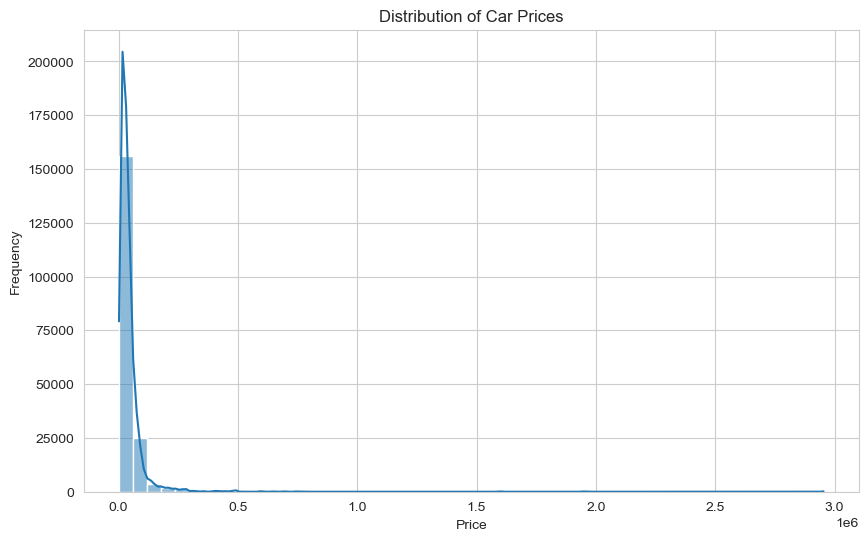

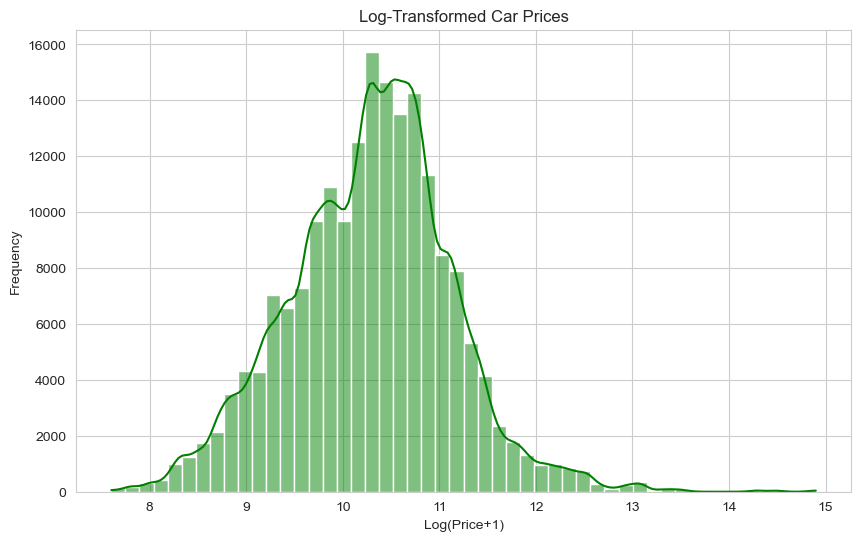

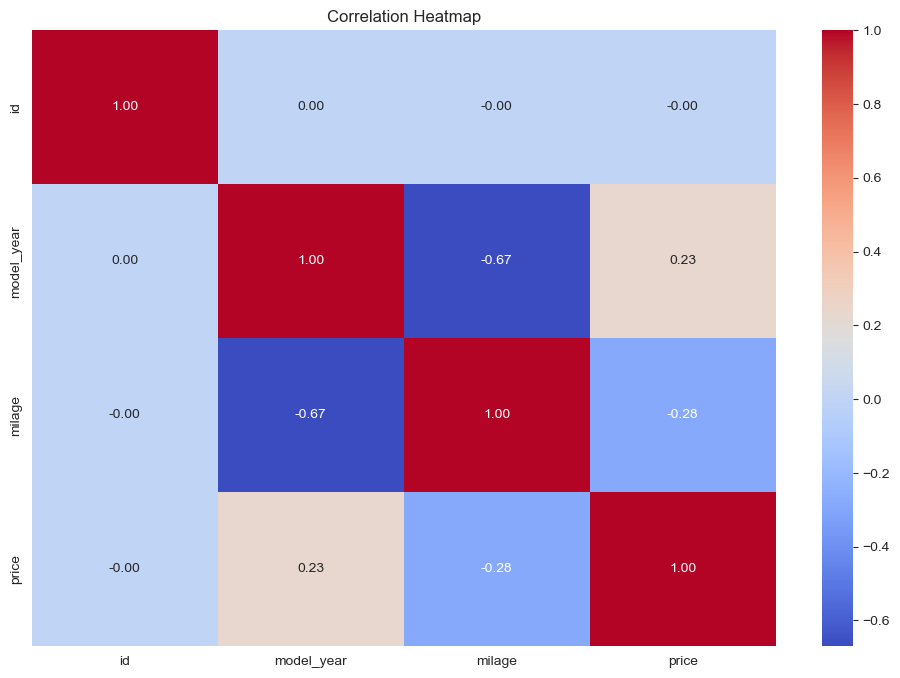

Plotting numerical variables vs price


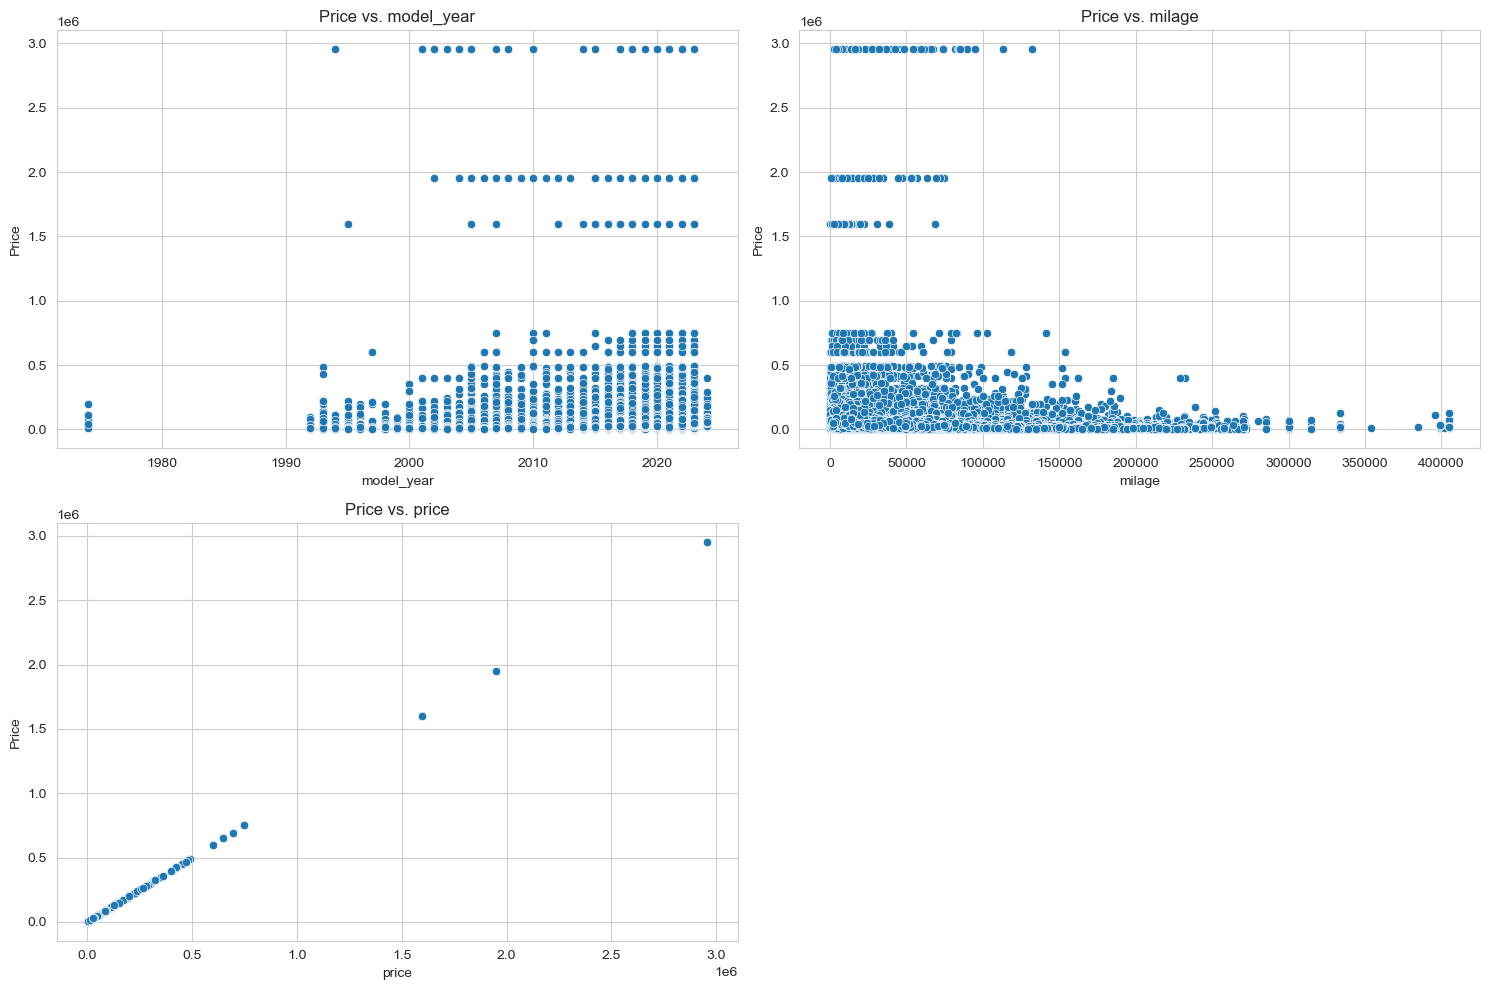

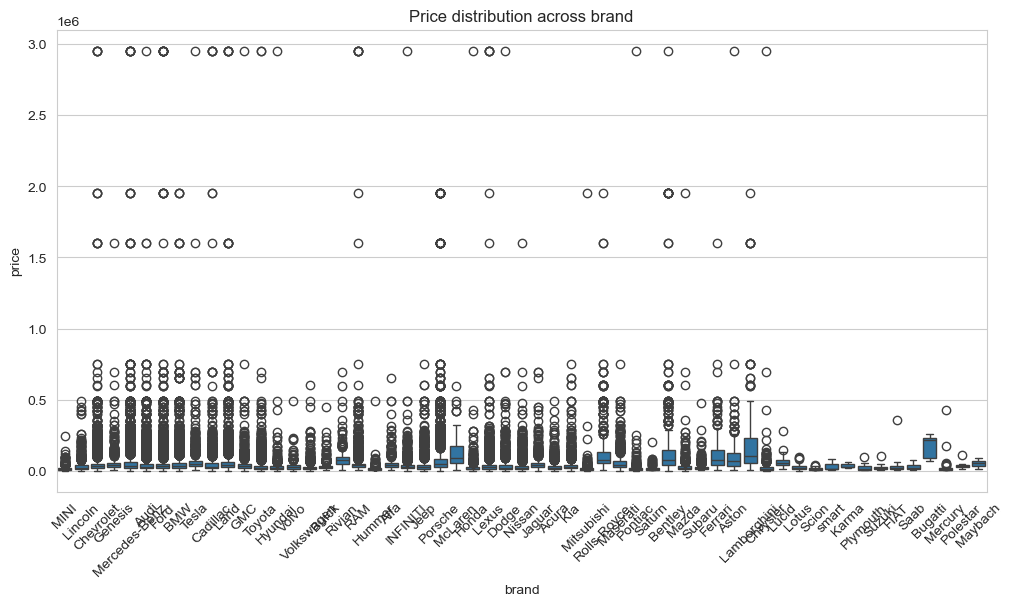

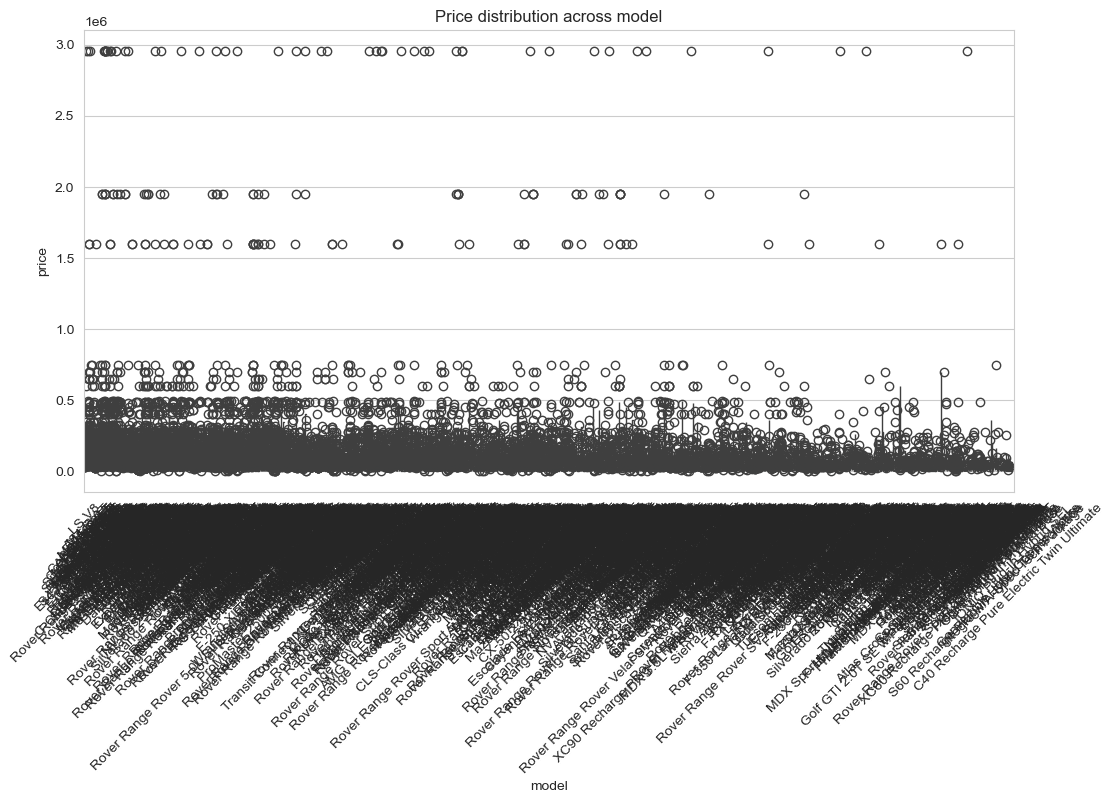

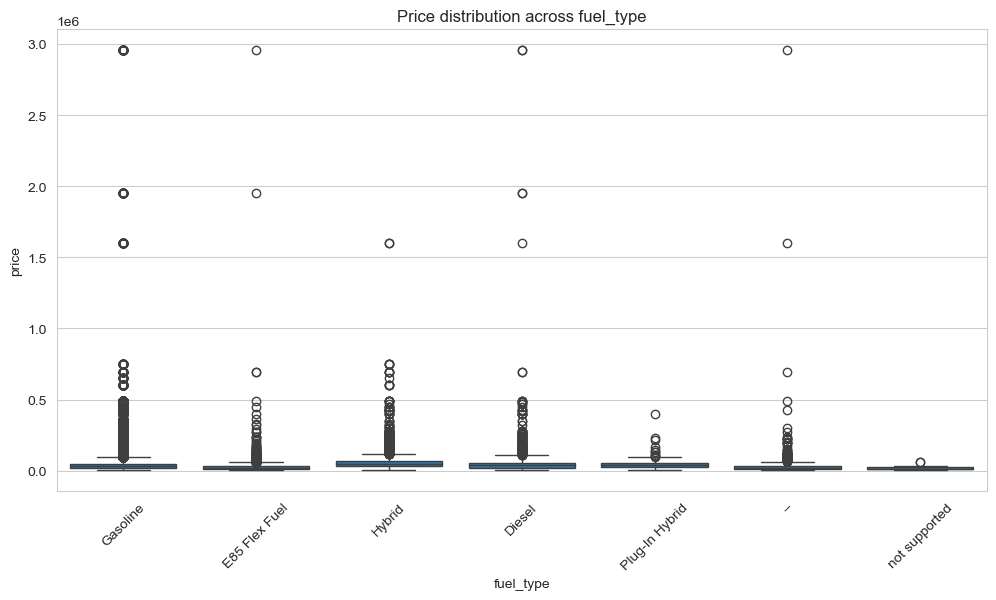

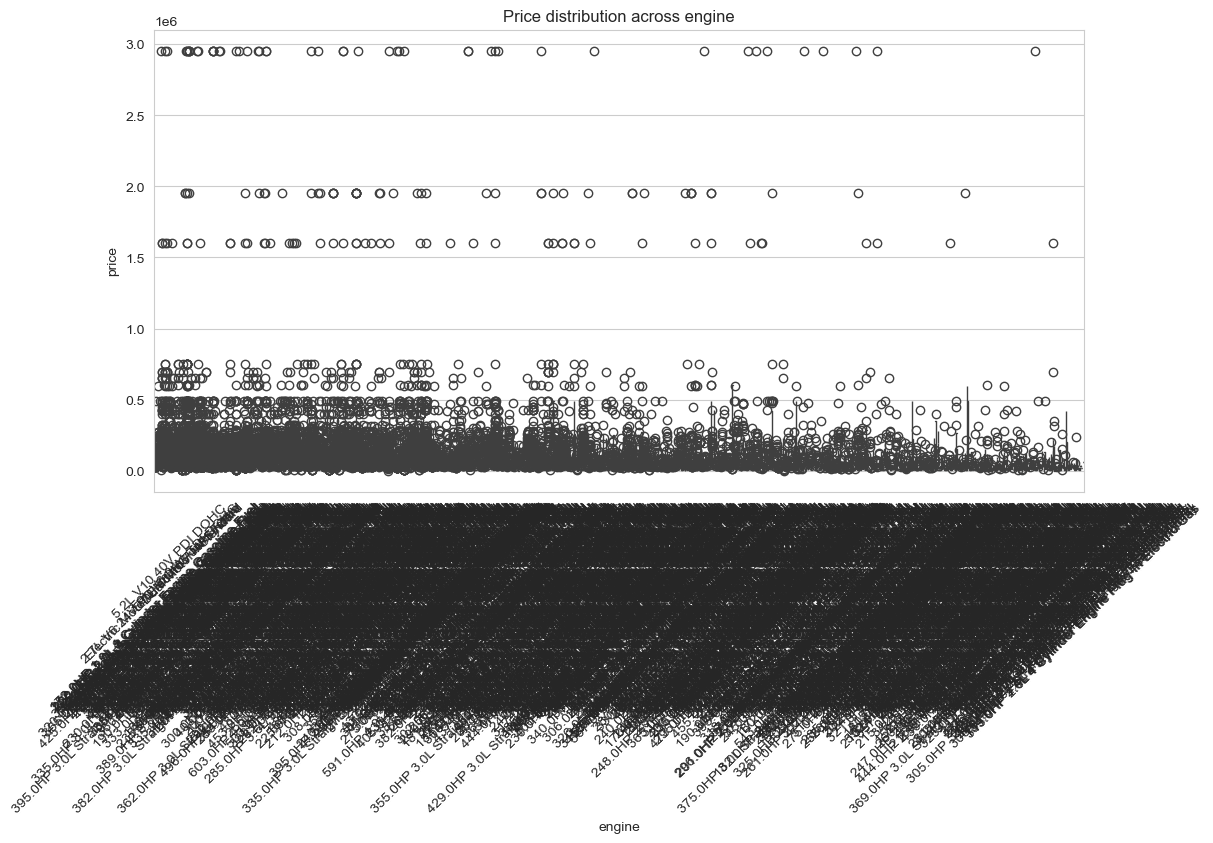

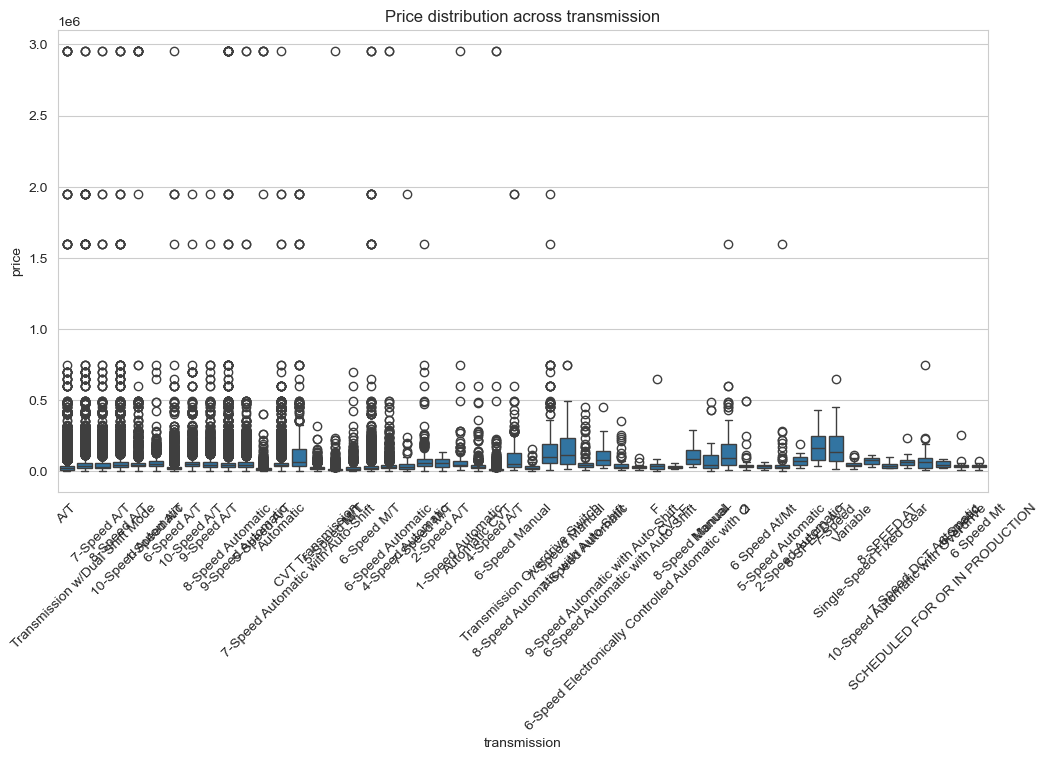

In [35]:
exploratory_data_analysis(train_df)

In [36]:
def filling_missing_values_in_numerical_columns(df):
    # Automatically find all numerical columns with missing values
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    missing_cols = [col for col in numerical_cols if df[col].isnull().sum() > 0]

    print(f"Numerical columns with missing values: {missing_cols}")

    for col in missing_cols:
        median_value = df[col].median()
        df[col] = df[col].fillna(median_value)  # no inplace warning
        print(f"Filled missing values in {col} with median: {median_value}")

    print("\nDataFrame after filling numerical missing values:")
    print(df.info())
    return df


In [8]:
def filling_missing_values_in_categorical_columns(df):
        categorical_cols_with_missing = ['model', 'fuel_type'] # Replace with your columns
        # You could fill missing values using the mode of each column. Feel free to choose your strategy
        for col in categorical_cols_with_missing:
            mode_value = df[col].mode()[0]
            df[col].fillna(mode_value, inplace=True)
        
        print("DataFrame after filling categorical missing values:")
        print(df.info())
        return df

In [37]:
def filling_missing_values_in_categorical_columns(df):
    # Automatically detect all categorical columns with missing values
    categorical_cols = df.select_dtypes(include=['object']).columns
    missing_cols = [col for col in categorical_cols if df[col].isnull().sum() > 0]

    print(f"Categorical columns with missing values: {missing_cols}")

    for col in missing_cols:
        # Strategy per column
        if col in ['fuel_type', 'transmission']:  
            # Mode makes sense here
            mode_value = df[col].mode()[0]
            df[col] = df[col].fillna(mode_value)
            print(f"Filled {col} with mode: {mode_value}")
        elif col in ['model', 'engine', 'ext_col', 'int_col']:  
            # Replace with "Unknown"
            df[col] = df[col].fillna("Unknown")
            print(f"Filled {col} with 'Unknown'")
        else:
            # Generic fallback
            df[col] = df[col].fillna("missing")
            print(f"Filled {col} with 'missing'")

    print("\nDataFrame after filling categorical missing values:")
    print(df.info())
    return df


In [38]:
def preprocessing(df, is_train=True):
    """
    Prepares the dataset for modeling.

    What it does:
    - Cleans up missing values
    - Creates new useful features (like car age, mileage per year, engine size, etc.)
    - Turns text columns into numbers the model can understand
    - Keeps the target column (price) only for training
    
    Args:
        df (pd.DataFrame): The input data
        is_train (bool): True if training data (keeps price), False for test data
    
    Returns:
        pd.DataFrame: A cleaned and ready-to-use dataframe
    """
    df = df.copy()  # so we don’t mess up the original

    # 1. Drop ID column if it exists (not useful for learning)
    if "id" in df.columns:
        df.drop("id", axis=1, inplace=True)

    # 2. Handle missing values
    df = filling_missing_values_in_numerical_columns(df)
    df = filling_missing_values_in_categorical_columns(df)

    # 3. Feature engineering (creating new info from old ones)
    if "model_year" in df.columns:
        df["car_age"] = 2025 - df["model_year"]

    if "milage" in df.columns and "model_year" in df.columns:
        df["milage_per_year"] = df["milage"] / (df["car_age"] + 1)  # avoid division by zero

    if "engine" in df.columns:
        # Pull out numbers from things like "2.0L"
        df["engine_size"] = df["engine"].str.extract(r'(\d+\.\d+|\d+)').astype(float)
        df["engine_size"].fillna(df["engine_size"].median(), inplace=True)

    if "accident" in df.columns:
        df["accident_flag"] = df["accident"].map({"Yes": 1, "No": 0}).fillna(-1)

    if "clean_title" in df.columns:
        df["clean_title_flag"] = df["clean_title"].map({"Yes": 1, "No": 0}).fillna(-1)

    # 4. Convert categorical columns into numbers
    df = encode_categorical_columns(df)

    # 5. Drop price in test data (since we don’t know it)
    if not is_train and "price" in df.columns:
        df.drop("price", axis=1, inplace=True)

    return df


In [39]:
df=preprocessing(train_df)

Numerical columns with missing values: []

DataFrame after filling numerical missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 17.3+ MB
None
Categorical columns with missing values: ['fuel_type', 'accident', 'clean_title']
Filled fuel_type with mode: Gasoline
Filled accident wit

In [41]:
# Separate features (everything except price) and target (price)
X = df.drop('price', axis=1)
y = df['price']

# Train-test split: 80% for training, 20% for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Data has been split!")
print(f"Training set size: {X_train.shape[0]} rows")
print(f"Validation set size: {X_val.shape[0]} rows")


Data has been split!
Training set size: 150826 rows
Validation set size: 37707 rows


In [42]:
print(X_train.head())

        brand  model  model_year  milage  fuel_type  engine  transmission  \
184031     36    764        2017   61675          1     258            49   
173831     39    732        2003  185000          2     323            38   
183819     14    670        2020   92000          2     651             2   
85525      19    583        2023    5483          2     441            20   
41872      11    457        2023    5000          2    1093            16   

        ext_col  int_col  accident  clean_title  car_age  milage_per_year  \
184031      128       14         0            0        8      6852.777778   
173831      263       71         0            0       22      8043.478261   
183819      128       71         0            0        5     15333.333333   
85525        29       14         1            1        2      1827.666667   
41872       234       14         1            0        2      1666.666667   

        engine_size  accident_flag  clean_title_flag  
184031        208.0

# Training your Model

In [43]:
def train_with_cv(estimator, param_grid, X, y, cv_splits=5, scoring=None):
    if scoring is None:
        scoring = "neg_root_mean_squared_error"

    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=kfold,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )

    print("Hyperparameter tuning in progress...")
    grid_search.fit(X, y)
    print("Best parameters found!")

    return grid_search.best_estimator_, grid_search.best_params_, grid_search.cv_results_


In [44]:
model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 150],     
    'max_depth': [8, 12, 16],       
    'min_samples_split': [2, 5, 10] 
}

best_model, best_params, cv_results = train_with_cv(
    model, param_grid, X_train, y_train
)

print("Best Params Found:", best_params)


Hyperparameter tuning in progress...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters found!
Best Params Found: {'max_depth': 8, 'min_samples_split': 10, 'n_estimators': 150}


In [47]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_val_pred = best_model.predict(X_val)

val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)

print(f"Validation RMSE: {val_rmse:.2f}")


Validation RMSE: 69048.83


In [48]:
# Retrain the final model with best hyperparameters on the full dataset
final_model = RandomForestRegressor(
    **best_params, 
    random_state=42,
    n_jobs=-1  # use all CPU cores to speed things up
)

X_full = np.vstack([X_train, X_val])
y_full = np.hstack([y_train, y_val])

final_model.fit(X_full, y_full)


RandomForestRegressor(max_depth=8, min_samples_split=10, n_estimators=150,
                      n_jobs=-1, random_state=42)

In [49]:
test=pd.read_csv("test.csv")
test.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [21]:
X_test=preprocessing(test)
X_test.head()

C:\Users\PC\AppData\Local\Temp\ipykernel_33112\904521727.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_33112\4218426678.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when do

DataFrame after filling numerical missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     122307 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      124058 non-null  object
 11  clean_title   111451 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB
None
DataFrame after filling categorical missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column       

C:\Users\PC\AppData\Local\Temp\ipykernel_33112\2107136911.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('missing', inplace=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_33112\2107136911.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when do

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,26,1388,2015,98000,2,326,16,302,10,1,0
1,188534,26,1375,2020,9142,3,787,31,261,14,1,0
2,188535,14,636,2022,28121,2,541,3,302,57,1,1
3,188536,3,182,2016,61258,2,193,39,259,14,1,1
4,188537,3,181,2018,59000,2,365,38,127,14,1,0


In [52]:
# Use the same training columns
train_columns = X_train.columns  # this works if X_train was originally a DataFrame

# Reindex test set to match training features
X_test = X_test.reindex(columns=train_columns, fill_value=0)

# Predict
y_test_pred = final_model.predict(X_test)
print(y_test_pred[:5])


[ 39905.03923768 183199.07339673 106961.11346764  27873.59067419
  35088.29857562]


In [55]:
# Keep a copy of raw test data
raw_test = test.copy()

X_test = preprocessing(test)

# Align with training features
X_test = X_test.reindex(columns=train_columns, fill_value=0)


y_test_pred = final_model.predict(X_test)

# Build submission
submission = pd.DataFrame({
    "id": raw_test["id"],  # take ids from raw test data
    "Price": y_test_pred
})

submission.to_csv("submission.csv", index=False)
print("Submission file saved!")


Numerical columns with missing values: []

DataFrame after filling numerical missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         125690 non-null  object
 1   model         125690 non-null  object
 2   model_year    125690 non-null  int64 
 3   milage        125690 non-null  int64 
 4   fuel_type     122307 non-null  object
 5   engine        125690 non-null  object
 6   transmission  125690 non-null  object
 7   ext_col       125690 non-null  object
 8   int_col       125690 non-null  object
 9   accident      124058 non-null  object
 10  clean_title   111451 non-null  object
dtypes: int64(2), object(9)
memory usage: 10.5+ MB
None
Categorical columns with missing values: ['fuel_type', 'accident', 'clean_title']
Filled fuel_type with mode: Gasoline
Filled accident with 'missing'
Filled clean_title with 'missin

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 1.5 MB/s eta 0:00:01
   ---------------------------- ----------- 1.0/1.5 MB 1.9 MB/s eta 0:00:01
   ------------------------------------ --- 1.3/1.5 MB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 1.9 MB/s eta 0:00:00
